# Exploring the data w/ mne

In [2]:
%pip install gensim

   ---------------------------------------- 0.0/24.0 MB ? eta -:--:--
   - -------------------------------------- 0.8/24.0 MB 4.8 MB/s eta 0:00:05
   --- ------------------------------------ 1.8/24.0 MB 4.8 MB/s eta 0:00:05
   ---- ----------------------------------- 2.9/24.0 MB 5.1 MB/s eta 0:00:05
   ------ --------------------------------- 4.2/24.0 MB 5.2 MB/s eta 0:00:04
   --------- ------------------------------ 5.8/24.0 MB 5.7 MB/s eta 0:00:04
   ------------ --------------------------- 7.6/24.0 MB 6.2 MB/s eta 0:00:03
   --------------- ------------------------ 9.4/24.0 MB 6.6 MB/s eta 0:00:03
   ------------------- -------------------- 11.5/24.0 MB 7.0 MB/s eta 0:00:02
   ---------------------- ----------------- 13.6/24.0 MB 7.4 MB/s eta 0:00:02
   -------------------------- ------------- 16.0/24.0 MB 7.8 MB/s eta 0:00:02
   ------------------------------ --------- 18.4/24.0 MB 8.1 MB/s eta 0:00:01
   ---------------------------------- ----- 20.7/24.0 MB 8.4 MB/s eta 0:00:01
 

In [2]:
import mne
import numpy as np
import pandas as pd
import keras

In [23]:
epochs = mne.read_epochs("Data/rsvp_session0_files135-142-epo.fif")
eeg_data = epochs.get_data() # NumPy array of shape [n_trials, n_electrodes, n_timepoints] with n_electrodes = 64, n_timepoints = 276 and n_trials is variable by each file.
metadata = epochs.metadata   # Pandas DataFrame

Reading c:\Users\wadem\OneDrive - UCB-O365\EEG2Text\EEG2Text\Clone\Data\rsvp_session0_files135-142-epo.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 64) active
    Found the data of interest:
        t =    -200.00 ...     900.00 ms
        0 CTF compensation matrices available
Adding metadata with 16 columns
6119 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated


In [19]:
print(epochs.event_id)

{'NOUN': 500, 'VERB': 501, 'ADJ': 502, 'DET': 503, 'PRON': 504, 'ADP': 505, 'ADV': 506, 'AUX': 507, 'CCONJ': 508, 'INTJ': 509, 'NUM': 510, 'PART': 511, 'PROPN': 512, 'PUNCT': 513, 'SCONJ': 514, 'X': 516}


The events are defined by their POS. 

In [20]:
evoked = epochs.average()

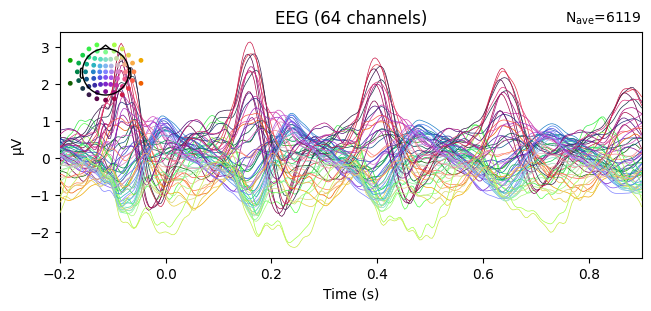

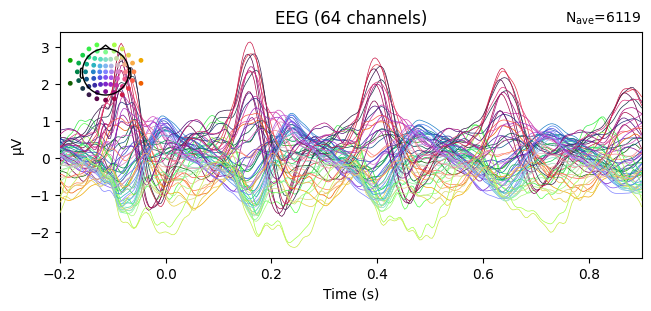

In [21]:
evoked.plot()

We can see the presentation rate on the posterior electrodes clearly, which is a good sanity check since those are the ones that process visual information. Let's compare nouns and verbs.

In [25]:
evoked_noun = epochs['NOUN'].average()
evoked_verb = epochs['VERB'].average()

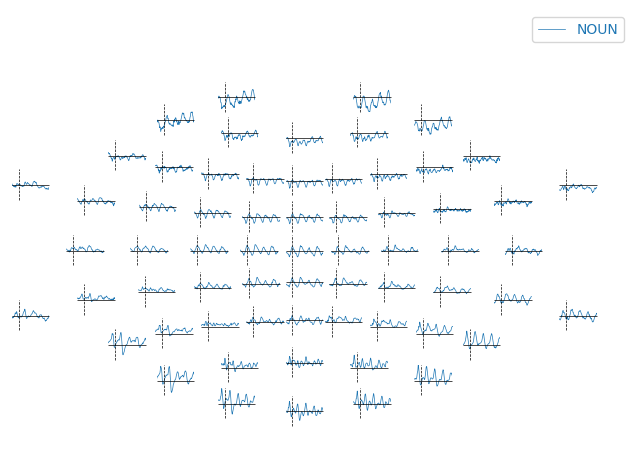

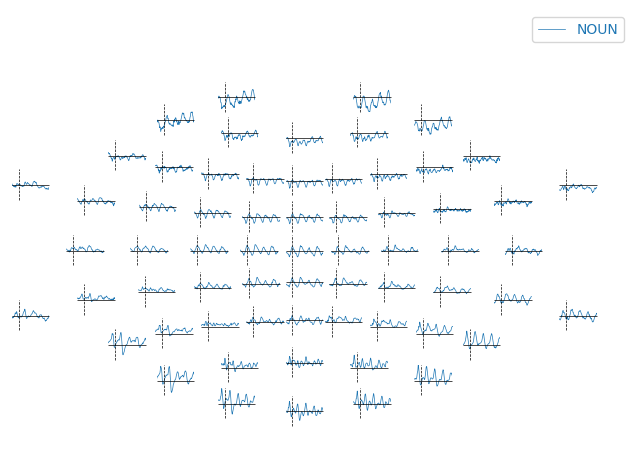

In [30]:
evoked_noun.plot_topo()

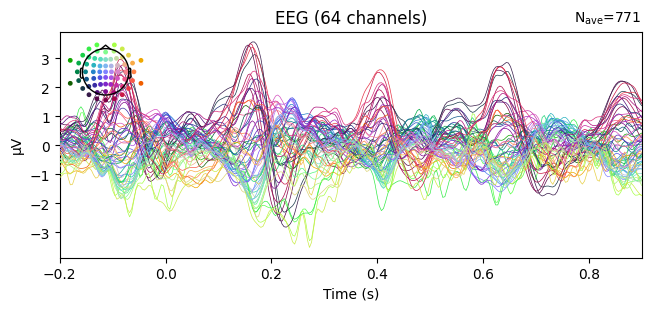

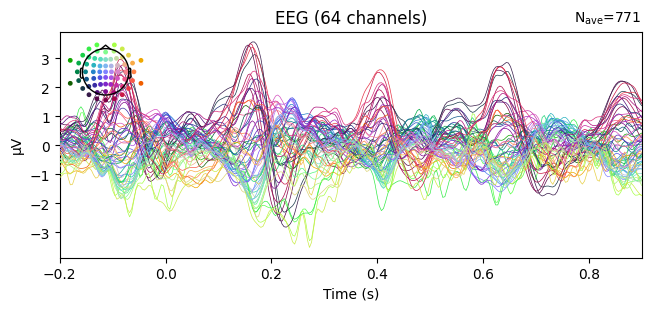

In [28]:
evoked_verb.plot()

# Getting vectors for the words and building the Semantic Module

In [8]:
import gensim.downloader

#The conceptnet-numberbatch seems to be a good option as it claims to encapulate meaning specifically from a bunch of different embedding types
model = gensim.downloader.load('conceptnet-numberbatch-17-06-300')


[==================================================] 100.0% 1168.7/1168.7MB downloaded


In [29]:
import keras

inputs = keras.Input(shape = (25,17,17,250)) #sentence length by x by y by time
x = keras.layers.Normalization(axis=None)(inputs)
x =  keras.layers.Conv3D(filters=32, kernel_size=(3,3,10), strides=1, activation='relu')(x)
x = keras.layers.Flatten()(x) #should only flatten across the word, not the whole sentence. Will fix.
sem_output = keras.layers.Dense(units=300)(x)

semantic = keras.Model(inputs, sem_output)
semantic.summary()

#semantic.compile(
#    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
#    loss=keras.losses.CosineSimilarity(),
#    metrics=keras.metrics.CosineSimilarity(),
#)


    

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 25, 17, 17,     │             0 │
│                                 │ 250)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_18                │ (None, 25, 17, 17,     │             3 │
│ (Normalization)                 │ 250)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_16 (Conv3D)              │ (None, 23, 15, 8, 32)  │       720,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 88320)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 300)            │    26,496,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,216,335 (103.82 MB)

 Trainable params: 27,216,332 (103.82 MB)

 Non-trainable params: 3 (16.00 B)